In [1]:
import math
import subprocess
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


2021-11-18 15:35:46.401798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-18 15:35:46.401822: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data preparation

In [2]:
dataframe = pd.read_csv('data/lab1/krkopt.csv')
dataframe


,wh_king_file,wh_king_rank,wh_rook_file,wh_rook_rank,bl_king_file,bl_king_rank,res
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,sixteen
28052,b,1,g,7,e,6,sixteen
28053,b,1,g,7,e,7,sixteen
28054,b,1,g,7,f,5,sixteen


In [3]:
dataframe = dataframe.replace({
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "draw": 17,
})
dataframe


,wh_king_file,wh_king_rank,wh_rook_file,wh_rook_rank,bl_king_file,bl_king_rank,res
0,a,1,b,3,c,2,17
1,a,1,c,1,c,2,17
2,a,1,c,1,d,1,17
3,a,1,c,1,d,2,17
4,a,1,c,2,c,1,17
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,16
28052,b,1,g,7,e,6,16
28053,b,1,g,7,e,7,16
28054,b,1,g,7,f,5,16


In [4]:
batch_size = 64
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


16833 train examples
5611 validation examples
5612 test examples


In [5]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=batch_size):
    df = dataframe.copy()
    labels = dataframe.pop('res')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test, shuffle=False)


/tmp/ipykernel_67750/491899032.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
2021-11-18 15:35:48.318712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-18 15:35:48.318738: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-18 15:35:48.318756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Arch): /proc/driver/nvidia/version does not exist
2021-11-18 15:35:48.319011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

In [6]:
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)

    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer


def get_category_encoding_layer(name, dataset, max_tokens=None):
    index = layers.StringLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    return lambda feature: encoder(index(feature))


In [7]:
all_inputs = []
encoded_features = []

for column in ['wh_king_rank', 'wh_rook_rank', 'bl_king_rank']:
    numeric_col = tf.keras.Input(shape=(1,), name=column)
    normalization_layer = get_normalization_layer(column, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

for column in ['wh_king_file', 'wh_rook_file', 'bl_king_file']:
    categorical_col = tf.keras.Input(shape=(1,), name=column, dtype='string')
    encoding_layer = get_category_encoding_layer(name=column,
                                                 dataset=train_ds,
                                                 max_tokens=8)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


In [8]:
def get_cp_callback(path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                              save_weights_only=True,
                                              save_freq=5 *
                                              (math.ceil(len(train) / batch_size) + 1),
                                              verbose=1)

def purge_checkpoints():
    if os.path.isdir(checkpoint_path):
        subprocess.run(['rm', '-rf', checkpoint_path])
        subprocess.run(['mkdir', checkpoint_path])

In [9]:
def plotHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')


# Dropout

Epoch 1/30
264/264 [==============================] - 3s 8ms/step - loss: 1.8884 - acc: 0.3054 - val_loss: 1.5095 - val_acc: 0.4341
Epoch 2/30
264/264 [==============================] - 2s 8ms/step - loss: 1.5119 - acc: 0.4283 - val_loss: 1.2674 - val_acc: 0.5266
Epoch 3/30
264/264 [==============================] - 2s 8ms/step - loss: 1.3521 - acc: 0.4808 - val_loss: 1.1477 - val_acc: 0.5520
Epoch 4/30
264/264 [==============================] - 2s 8ms/step - loss: 1.2840 - acc: 0.5006 - val_loss: 1.0703 - val_acc: 0.5887
Epoch 5/30
264/264 [==============================] - 2s 9ms/step - loss: 1.2051 - acc: 0.5299 - val_loss: 1.0376 - val_acc: 0.5910
Epoch 6/30
  1/264 [..............................] - ETA: 19s - loss: 1.1368 - acc: 0.6250
Epoch 00006: saving model to ./checkpoints/dropout/cp-0006.ckpt
264/264 [==============================] - 2s 9ms/step - loss: 1.1749 - acc: 0.5395 - val_loss: 0.9747 - val_acc: 0.6223
Epoch 7/30
264/264 [==============================] - 2s 8ms/st

2021-11-18 15:36:57.089347: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/drop_0.3/assets


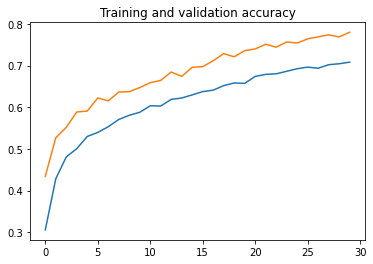

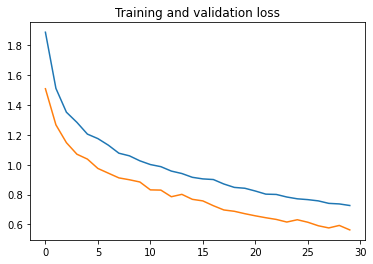

In [10]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/dropout/'
p = 0.5

purge_checkpoints()

x = layers.Dense(512, activation="relu")(all_features)
d1 = layers.Dropout(p)(x)
x1 = layers.Dense(512, activation="relu")(d1)
d2 = layers.Dropout(p)(x1)
x2 = layers.Dense(1024, activation="relu")(d2)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/drop_0.3')
plotHistory(history)


# Activation function

Epoch 1/20
264/264 [==============================] - 3s 9ms/step - loss: 1.9590 - acc: 0.2960 - val_loss: 1.9006 - val_acc: 0.3060
Epoch 2/20
264/264 [==============================] - 2s 8ms/step - loss: 1.7422 - acc: 0.3576 - val_loss: 1.7385 - val_acc: 0.3618
Epoch 3/20
264/264 [==============================] - 2s 8ms/step - loss: 1.5386 - acc: 0.4233 - val_loss: 1.5055 - val_acc: 0.4422
Epoch 4/20
264/264 [==============================] - 2s 7ms/step - loss: 1.4186 - acc: 0.4605 - val_loss: 1.3834 - val_acc: 0.4889
Epoch 5/20
264/264 [==============================] - 2s 7ms/step - loss: 1.3379 - acc: 0.4850 - val_loss: 1.3275 - val_acc: 0.4880
Epoch 6/20
  1/264 [..............................] - ETA: 18s - loss: 1.7950 - acc: 0.4375
Epoch 00006: saving model to ./checkpoints/afun/cp-0006.ckpt
264/264 [==============================] - 2s 8ms/step - loss: 1.3170 - acc: 0.4962 - val_loss: 1.3205 - val_acc: 0.5051
Epoch 7/20
264/264 [==============================] - 2s 8ms/step 

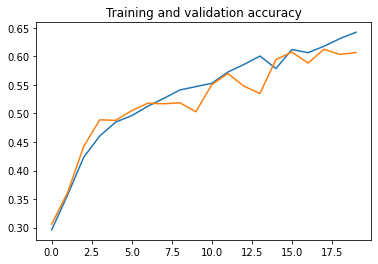

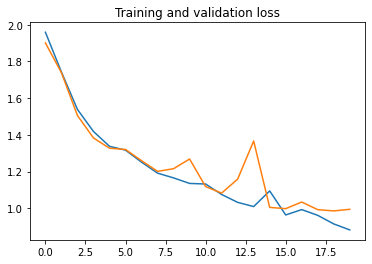

In [11]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/afun/'
func = 'selu'

purge_checkpoints()

x = layers.Dense(512, activation=func)(all_features)
x1 = layers.Dense(512, activation=func)(x)
x2 = layers.Dense(1024, activation=func)(x1)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/afun_selu')
plotHistory(history)


# Regularization

Epoch 1/30
264/264 [==============================] - 3s 9ms/step - loss: 3.1936 - acc: 0.3049 - val_loss: 2.1277 - val_acc: 0.2955
Epoch 2/30
264/264 [==============================] - 2s 8ms/step - loss: 1.9825 - acc: 0.3542 - val_loss: 1.9412 - val_acc: 0.3529
Epoch 3/30
264/264 [==============================] - 2s 8ms/step - loss: 1.9019 - acc: 0.3857 - val_loss: 1.8853 - val_acc: 0.3703
Epoch 4/30
264/264 [==============================] - 2s 8ms/step - loss: 1.8451 - acc: 0.4122 - val_loss: 1.8713 - val_acc: 0.4131
Epoch 5/30
264/264 [==============================] - 2s 8ms/step - loss: 1.7870 - acc: 0.4414 - val_loss: 1.7374 - val_acc: 0.4748
Epoch 6/30
  1/264 [..............................] - ETA: 23s - loss: 1.8737 - acc: 0.2969
Epoch 00006: saving model to ./checkpoints/reg/cp-0006.ckpt
264/264 [==============================] - 3s 10ms/step - loss: 1.7086 - acc: 0.4816 - val_loss: 1.7364 - val_acc: 0.4497
Epoch 7/30
264/264 [==============================] - 2s 9ms/step 

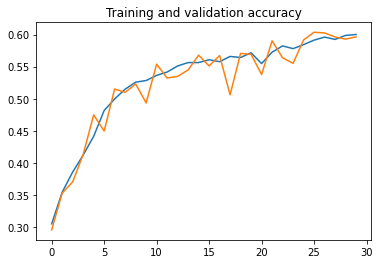

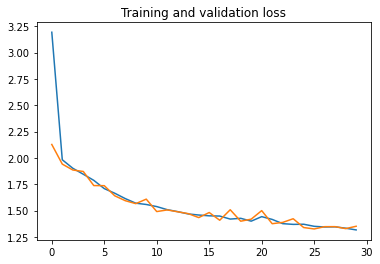

In [12]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/reg/'
reg = tf.keras.regularizers.L2(0.01)

purge_checkpoints()

x = layers.Dense(512, activation="relu", bias_regularizer=reg,
                 kernel_regularizer=reg, activity_regularizer=reg)(all_features)
x1 = layers.Dense(512, activation="relu", bias_regularizer=reg,
                  kernel_regularizer=reg, activity_regularizer=reg)(x)
x2 = layers.Dense(1024, activation="relu", bias_regularizer=reg,
                  kernel_regularizer=reg, activity_regularizer=reg)(x1)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/reg_L2(0.01)')
plotHistory(history)


# Bias initializer

Epoch 1/20
264/264 [==============================] - 3s 9ms/step - loss: 1.5961 - acc: 0.4088 - val_loss: 1.2790 - val_acc: 0.4908
Epoch 2/20
264/264 [==============================] - 2s 7ms/step - loss: 1.0999 - acc: 0.5659 - val_loss: 1.0362 - val_acc: 0.5960
Epoch 3/20
264/264 [==============================] - 2s 7ms/step - loss: 0.9326 - acc: 0.6215 - val_loss: 0.9372 - val_acc: 0.6225
Epoch 4/20
264/264 [==============================] - 2s 7ms/step - loss: 0.8137 - acc: 0.6692 - val_loss: 0.8355 - val_acc: 0.6571
Epoch 5/20
264/264 [==============================] - 2s 7ms/step - loss: 0.7433 - acc: 0.6998 - val_loss: 0.7275 - val_acc: 0.7013
Epoch 6/20
  1/264 [..............................] - ETA: 18s - loss: 0.4941 - acc: 0.8281
Epoch 00006: saving model to ./checkpoints/binit/cp-0006.ckpt
264/264 [==============================] - 2s 8ms/step - loss: 0.6265 - acc: 0.7475 - val_loss: 0.7026 - val_acc: 0.7156
Epoch 7/20
264/264 [==============================] - 2s 7ms/step

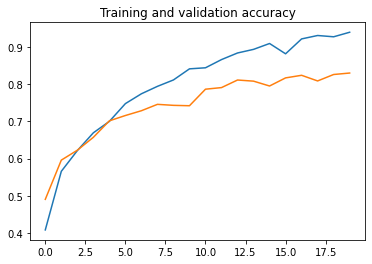

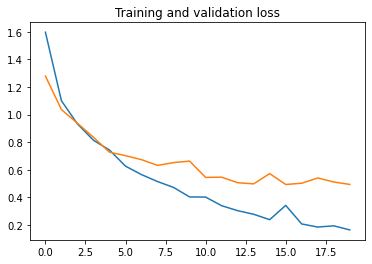

In [13]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/binit/'
p = 0.1

purge_checkpoints()

x = layers.Dense(512, activation="relu",
                 bias_initializer="he_normal")(all_features)
x1 = layers.Dense(512, activation="relu", bias_initializer="he_normal")(x)
x2 = layers.Dense(1024, activation="relu", bias_initializer="he_normal")(x1)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/binit_henormal')
plotHistory(history)


# Optimizers

Epoch 1/20
264/264 [==============================] - 3s 8ms/step - loss: 2.5827 - acc: 0.1690 - val_loss: 2.3564 - val_acc: 0.1912
Epoch 2/20
264/264 [==============================] - 2s 7ms/step - loss: 2.2562 - acc: 0.2415 - val_loss: 2.1770 - val_acc: 0.2821
Epoch 3/20
264/264 [==============================] - 2s 7ms/step - loss: 2.1042 - acc: 0.2836 - val_loss: 2.0638 - val_acc: 0.2793
Epoch 4/20
264/264 [==============================] - 2s 7ms/step - loss: 1.9966 - acc: 0.3078 - val_loss: 1.9630 - val_acc: 0.3165
Epoch 5/20
264/264 [==============================] - 2s 8ms/step - loss: 1.9064 - acc: 0.3319 - val_loss: 1.8944 - val_acc: 0.3367
Epoch 6/20
  1/264 [..............................] - ETA: 19s - loss: 1.8975 - acc: 0.2656
Epoch 00006: saving model to ./checkpoints/opt/cp-0006.ckpt
264/264 [==============================] - 2s 8ms/step - loss: 1.8287 - acc: 0.3573 - val_loss: 1.8251 - val_acc: 0.3335
Epoch 7/20
264/264 [==============================] - 2s 8ms/step -

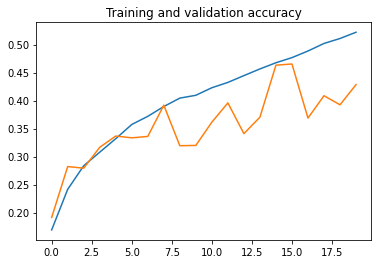

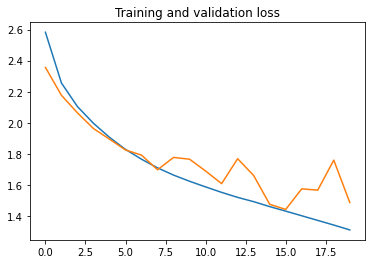

In [14]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/opt/'

purge_checkpoints()

x = layers.Dense(512, activation='relu')(all_features)
x1 = layers.Dense(512, activation='relu')(x)
x2 = layers.Dense(1024, activation='relu')(x1)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.SGD(nesterov=True, momentum=0.25),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/opt_sgd_nesterov')
plotHistory(history)

# Learning rate

Epoch 1/40
264/264 [==============================] - 2s 7ms/step - loss: 1.7181 - acc: 0.3764 - val_loss: 1.3977 - val_acc: 0.4627
Epoch 2/40
264/264 [==============================] - 2s 7ms/step - loss: 1.2215 - acc: 0.5336 - val_loss: 1.1122 - val_acc: 0.5577
Epoch 3/40
264/264 [==============================] - 2s 7ms/step - loss: 1.0402 - acc: 0.5907 - val_loss: 1.0438 - val_acc: 0.5876
Epoch 4/40
264/264 [==============================] - 2s 7ms/step - loss: 0.9408 - acc: 0.6233 - val_loss: 0.9503 - val_acc: 0.6174
Epoch 5/40
264/264 [==============================] - 2s 7ms/step - loss: 0.8583 - acc: 0.6531 - val_loss: 0.8534 - val_acc: 0.6576
Epoch 6/40
  1/264 [..............................] - ETA: 19s - loss: 0.7148 - acc: 0.7344
Epoch 00006: saving model to ./checkpoints/lrate/cp-0006.ckpt
264/264 [==============================] - 2s 9ms/step - loss: 0.7800 - acc: 0.6844 - val_loss: 0.8499 - val_acc: 0.6612
Epoch 7/40
264/264 [==============================] - 2s 7ms/step

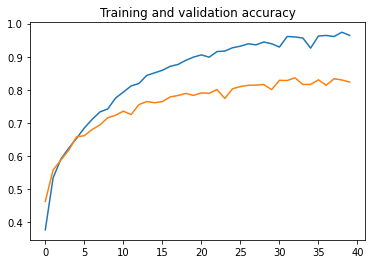

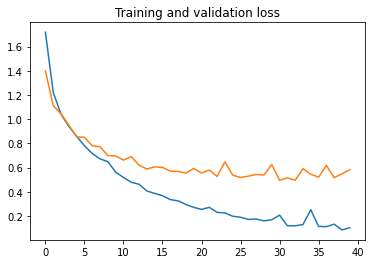

In [15]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/lrate/'

purge_checkpoints()

x = layers.Dense(512, activation='relu')(all_features)
x1 = layers.Dense(512, activation='relu')(x)
x2 = layers.Dense(1024, activation='relu')(x1)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=40,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/lrate_0.0005')
plotHistory(history)

# Final variant

Epoch 1/50
264/264 [==============================] - 3s 8ms/step - loss: 1.7635 - acc: 0.3550 - val_loss: 1.4741 - val_acc: 0.4167
Epoch 2/50
264/264 [==============================] - 2s 7ms/step - loss: 1.2907 - acc: 0.5069 - val_loss: 1.1405 - val_acc: 0.5523
Epoch 3/50
264/264 [==============================] - 2s 7ms/step - loss: 1.1177 - acc: 0.5638 - val_loss: 1.0353 - val_acc: 0.5860
Epoch 4/50
264/264 [==============================] - 2s 7ms/step - loss: 1.0232 - acc: 0.5925 - val_loss: 0.9705 - val_acc: 0.6204
Epoch 5/50
264/264 [==============================] - 2s 8ms/step - loss: 0.9485 - acc: 0.6208 - val_loss: 0.9299 - val_acc: 0.6227
Epoch 6/50
  1/264 [..............................] - ETA: 19s - loss: 1.0702 - acc: 0.5781
Epoch 00006: saving model to ./checkpoints/_best/cp-0006.ckpt
264/264 [==============================] - 2s 9ms/step - loss: 0.8841 - acc: 0.6447 - val_loss: 0.8487 - val_acc: 0.6614
Epoch 7/50
264/264 [==============================] - 2s 8ms/step

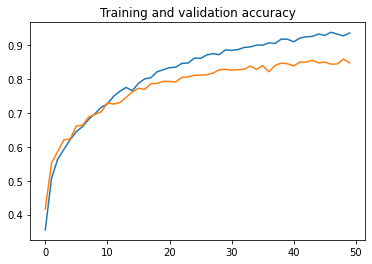

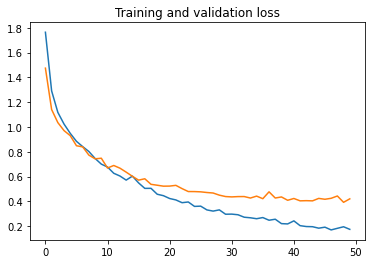

In [16]:
all_features = tf.keras.layers.concatenate(encoded_features)

checkpoint_path = './checkpoints/_best/'
p = 0.1
batch_size = 64

purge_checkpoints()

x = layers.Dense(512, activation="relu", bias_initializer="he_normal")(all_features)
d1 = layers.Dropout(p)(x)
x1 = layers.Dense(512, activation="relu", bias_initializer="he_normal")(d1)
d2 = layers.Dropout(p)(x1)
x2 = layers.Dense(1024, activation="relu", bias_initializer="he_normal")(d2)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    batch_size=batch_size,
                    callbacks=[get_cp_callback(checkpoint_path + 'cp-{epoch:04d}.ckpt')])

model.save('./models/_best')
plotHistory(history)

# Testing

In [17]:
test_model = models.load_model('models/_best')
test_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wh_king_file (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 wh_rook_file (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 bl_king_file (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 wh_king_rank (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

In [18]:
loss, acc = test_model.evaluate(x=test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

88/88 - 0s - loss: 0.4154 - acc: 0.8535 - 408ms/epoch - 5ms/step
Restored model, accuracy: 85.35%
